In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy import stats

import treeswift as ts

In [2]:
taxdict = {}
tree = ts.read_tree_newick('../data/metazoan_tree.nwk')
for tax in ['Echinodermata', 'Cnidaria', 'Ctenophora', 'Mollusca', 'Chordata', 'Arthropoda', 'Platyhelminthes', 'Annelida', 'Nematoda']:
    for node in tree.root.traverse_bfs():
        if node[0].label.strip("'") == tax:
            for i in node[0].traverse_leaves():
                taxdict[i.label.strip("'").replace(' ', '_')] = tax 

In [4]:
pilot_df = pd.read_csv('../data/pilot_data.txt', sep='\t')
metadata_df = pd.read_csv('../data/parsed_metazoans.out', sep='\t', names=['species', 'genomefile', 'ftppath', 'N50'])
pilot_df = pilot_df.merge(metadata_df, on='species', how='inner').drop(['ftppath', 'genomefile'], axis=1)
pilot_df = pilot_df.loc[pilot_df.N50 > 50000]
pilot_df['genus'] = pilot_df['species'].apply(lambda x: x.split('_')[0])
pilot_df['taxonomy'] = pilot_df.species.apply(taxdict.get)
genus_df = pilot_df.groupby('genus').sample(1)
genus_df = genus_df.loc[genus_df.zfs > 10 & (genus_df.retroelements > 10)]
print(pilot_df)

                       species  zfs  rnases   rvt1  rvt2  pol_mav  helitrons  \
0             Limosa_lapponica  204      46   2753     0       41          0   
1           Strix_occidentalis  355     569  12226     0       71          0   
2              Tyrannus_savana  284      56   1453     0       18          0   
5           Tursiops_truncatus  669      61  41741     0        2          0   
6            Zaprionus_taronus  246    1062    758   147        0          3   
...                        ...  ...     ...    ...   ...      ...        ...   
2849     Lamprotornis_superbus  337     141   1616     1       11          0   
2850  Drosophila_kurseongensis  237    2142   2328   206        1        258   
2851         Proteles_cristata  642      44   6318     0        2          0   
2852         Otocyon_megalotis  600      34   3236     0        1          0   
2854       Urocitellus_parryii  739      14   4230     0        2          0   

      retroelements        N50         

In [5]:
pilot_df[['species', 'taxonomy']].to_csv('/Users/jonwells/Desktop/metazoan_taxonomy.txt', sep='\t', index=False, header=False)

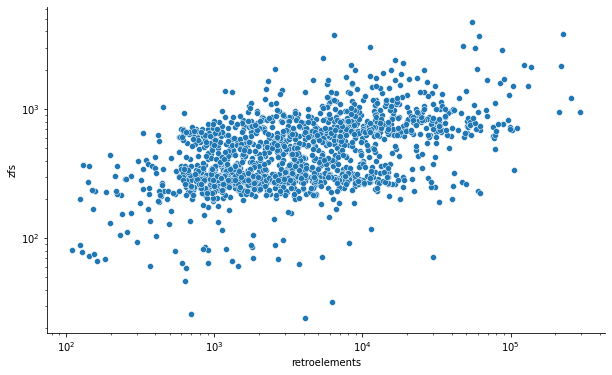

SpearmanrResult(correlation=0.4731914123663936, pvalue=5.588834039743797e-86)


In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=genus_df.loc[(genus_df.zfs > 10) & (genus_df.retroelements > 100)],
                x='retroelements',
                y='zfs',
                ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
sns.despine()

plt.show()

# fig, ax = plt.subplots(figsize=(10, 6))
# sns.scatterplot(data=genus_df,
#                 x='zfs',
#                 y='retroelements',
#                 ax=ax)
# ax.set_xscale('log')
# ax.set_yscale('log')
# sns.despine()

print(stats.spearmanr(genus_df.loc[(genus_df.zfs > 10) & (genus_df.retroelements > 100)].zfs,
                      genus_df.loc[(genus_df.zfs > 10) & (genus_df.retroelements > 100)].retroelements))
# print(stats.spearmanr(pilot_df.retroelements,
#                       pilot_df.N50))

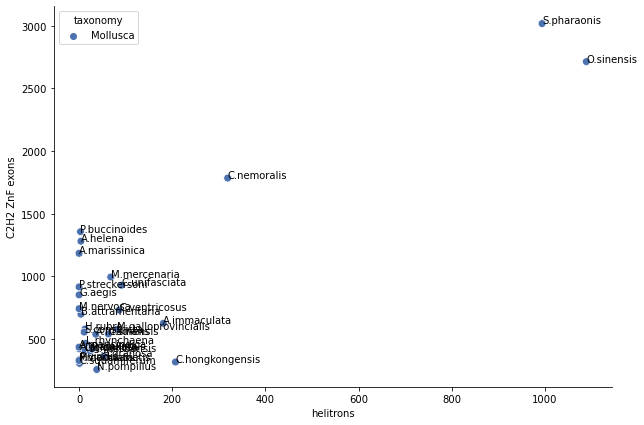

SpearmanrResult(correlation=0.22703735467994268, pvalue=0.2114401473334633)


In [43]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=genus_df.loc[pilot_df.taxonomy == 'Mollusca'],
                x='helitrons',
                y='zfs',
                hue='taxonomy',
                style='taxonomy',
                palette='deep',
                s=60,
                ax=ax)
for row in genus_df.loc[genus_df.taxonomy == 'Mollusca'].iterrows():
    s=row[1].species.split('_')[0][0] + '.' + row[1].species.split('_')[1]
    ax.text(x=row[1].helitrons, y=row[1].zfs, s=s)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('helitrons')
ax.set_ylabel('C2H2 ZnF exons')
sns.despine()
plt.savefig('../figs/mollusca_genus_zf_helitrons.pdf', bbox_inches='tight')
plt.show()
# print(stats.spearmanr(genus_df.retroelements, genus_df.zfs))


print(stats.spearmanr(genus_df.loc[genus_df.taxonomy == 'Mollusca'].zfs,
                      genus_df.loc[genus_df.taxonomy == 'Mollusca'].helitrons))

                log_zfs                                                    \
                  count      mean       std       min       25%       50%   
taxonomy                                                                    
Annelida            3.0  5.694346  0.774921  5.129899  5.252589  5.375278   
Arthropoda        294.0  5.886987  0.530802  2.397895  5.569297  5.812627   
Chordata          470.0  6.397745  0.546180  5.455321  5.924923  6.455199   
Cnidaria            8.0  5.718153  0.597103  4.912655  5.323689  5.740459   
Ctenophora          1.0  5.365976       NaN  5.365976  5.365976  5.365976   
Echinodermata       5.0  5.944525  0.300093  5.556828  5.690359  6.089045   
Mollusca           25.0  6.486325  0.653031  5.541264  6.037871  6.428105   
Nematoda           33.0  4.456252  0.386476  3.178054  4.234107  4.394449   
Platyhelminthes    11.0  5.109849  0.857812  4.174387  4.583090  4.820282   

                                     
                      75%       max  

/Users/jonwells/miniconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


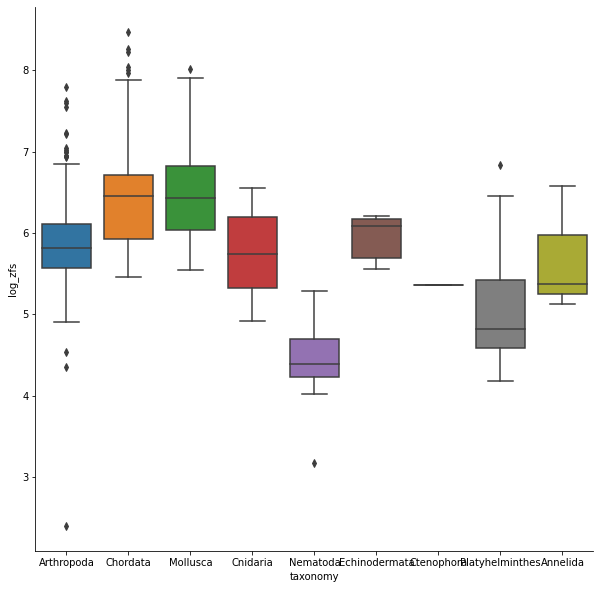

In [116]:
genus_df['log_zfs'] = np.log(genus_df.zfs)
genus_df['log_retroelements'] = np.log(genus_df.retroelements)
print(genus_df[['species', 'taxonomy', 'log_zfs']].groupby('taxonomy').describe())

fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=genus_df, x='taxonomy', y='log_zfs')
sns.despine()
plt.show()